## MNIST CNN

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

### Data

In [3]:
path = untar_data(URLs.MNIST)

In [4]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/mnist_png/training'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/testing')]

In [5]:
il = ImageList.from_folder(path, convert_mode="L")

In [6]:
il.items[0]

PosixPath('/home/jupyter/.fastai/data/mnist_png/training/9/39781.png')

In [11]:
defaults.cmap = 'binary'

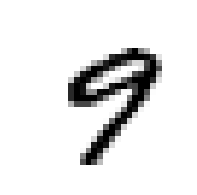

In [13]:
il[0].show()

In [15]:
sd = il.split_by_folder(train='training', valid='testing')

In [16]:
sd

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /home/jupyter/.fastai/data/mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /home/jupyter/.fastai/data/mnist_png;

Test: None

In [17]:
(path/'training').ls()

[PosixPath('/home/jupyter/.fastai/data/mnist_png/training/9'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/7'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/2'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/6'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/1'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/4'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/5'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/0'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/8'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/3')]

In [18]:
ll = sd.label_from_folder()

In [19]:
ll

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
9,9,9,9,9
Path: /home/jupyter/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
9,9,9,9,9
Path: /home/jupyter/.fastai/data/mnist_png;

Test: None

In [20]:
x, y = ll.train[0]

9 torch.Size([1, 28, 28])


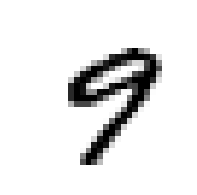

In [21]:
x.show()
print(y, x.shape)

In [23]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])

In [24]:
ll = ll.transform(tfms)

In [25]:
bs = 128

In [26]:
data = ll.databunch(bs=bs).normalize()

In [27]:
x, y = data.train_ds[0]

9 torch.Size([1, 28, 28])


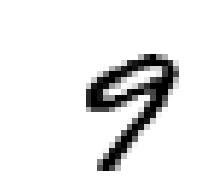

In [28]:
x.show()
print(y, x.shape)

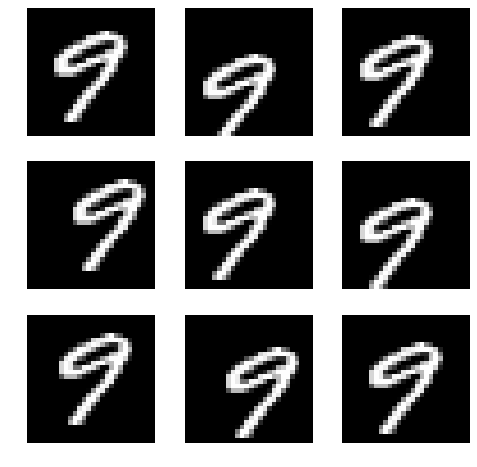

In [30]:
def _plot(i, j, ax): data.train_ds[0][0].show(ax, cmap='gray')
    
plot_multi(_plot, 3, 3, figsize=(8, 8))

In [31]:
xb, yb = data.one_batch()
xb.shape, yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

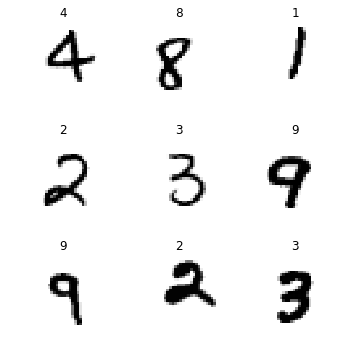

In [32]:
data.show_batch(rows=3, figsize=(5, 5))

### Basic CNN with batchnorm

In [33]:
def conv(ni, nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [35]:
model = nn.Sequential(
    conv(1, 8),  # 14
    nn.BatchNorm2d(8), 
    nn.ReLU(), 
    
    conv(8, 16), # 7
    nn.BatchNorm2d(16), 
    nn.ReLU(), 
    
    conv(16, 32), # 4
    nn.BatchNorm2d(32), 
    nn.ReLU(), 
    
    conv(32, 16), # 2
    nn.BatchNorm2d(16), 
    nn.ReLU(), 
    
    conv(16, 10), # 1
    nn.BatchNorm2d(10), 
    Flatten()     # remove (1, 1) grid
)

In [36]:
learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

In [37]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
______________________________________________________________

In [38]:
xb = xb.cuda()

AssertionError: 
Found no NVIDIA driver on your system. Please check that you
have an NVIDIA GPU and installed a driver from
http://www.nvidia.com/Download/index.aspx

In [40]:
model(xb).shape

torch.Size([128, 10])

In [41]:
learn.lr_find(end_lr=100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


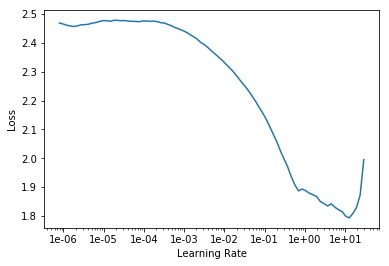

In [42]:
learn.recorder.plot()

In [43]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.230816,0.198538,0.941000,00:21
1,0.130799,0.116671,0.962700,00:22
2,0.071284,0.039792,0.986900,00:22


### Refactor

In [44]:
def conv2(ni, nf): return conv_layer(ni, nf, stride=2)

In [45]:
model = nn.Sequential(
    conv2(1, 8), 
    conv2(8, 16), 
    conv2(16, 32), 
    conv2(32, 16), 
    conv2(16, 13), 
    Flatten()


)

In [46]:
learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

In [47]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.245415,0.189933,0.941400,00:21
1,0.188712,0.219043,0.931300,00:22
2,0.162434,0.190737,0.939800,00:22
3,0.148316,0.114323,0.964100,00:22
4,0.124263,0.093409,0.970200,00:21
5,0.107872,0.060622,0.982200,00:22
6,0.083703,0.056931,0.982500,00:22
7,0.066657,0.037510,0.988100,00:22
8,0.049050,0.029702,0.991300,00:22
9,0.043824,0.026246,0.992400,00:22


### Resnet-ish

In [48]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf, nf)
        self.conv2 = conv_layer(nf, nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [49]:
help(res_block)

Help on function res_block in module fastai.layers:

res_block(nf, dense: bool = False, norm_type: Union[fastai.layers.NormType, NoneType] = <NormType.Batch: 1>, bottle: bool = False, **conv_kwargs)
    Resnet block of `nf` features. `conv_kwargs` are passed to `conv_layer`.



In [51]:
model = nn.Sequential(
    conv2(1, 8), 
    res_block(8), 
    conv2(8, 16), 
    res_block(16), 
    conv2(16, 32), 
    res_block(32), 
    conv2(32, 16), 
    res_block(16), 
    conv2(16, 10), 
    Flatten()    
)

In [52]:
def conv_and_res(ni, nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [55]:
model = nn.Sequential(
    conv_and_res(1, 8), 
    conv_and_res(8, 16), 
    conv_and_res(16, 32), 
    conv_and_res(32, 16), 
    conv2(16, 10), 
    Flatten()
)

In [56]:
learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

In [57]:
learn.lr_find(end_lr=100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


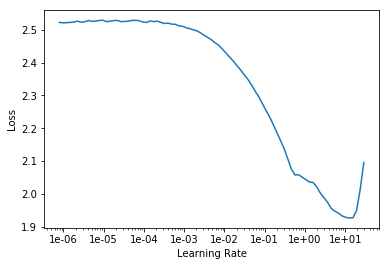

In [58]:
learn.recorder.plot()

In [59]:
learn.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.243555,0.177790,0.953500,00:34
1,0.131257,0.217138,0.932900,00:35
2,0.104340,0.178024,0.946700,00:35
3,0.081599,0.094708,0.970900,00:35
4,0.075318,0.188578,0.943200,00:35
5,0.060029,0.044880,0.986300,00:36
6,0.056718,0.049766,0.985600,00:35
7,0.047047,0.051771,0.983300,00:35
8,0.031049,0.022543,0.993400,00:35
9,0.024517,0.019163,0.993600,00:34


In [64]:
learn.fit_one_cycle(5, max_lr=0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.023343,0.019080,0.993800,00:34
1,0.023411,0.021603,0.993700,00:35
2,0.021236,0.018512,0.994200,00:34
3,0.018705,0.016067,0.995100,00:34
4,0.017870,0.015373,0.994900,00:35


In [60]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          72         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________

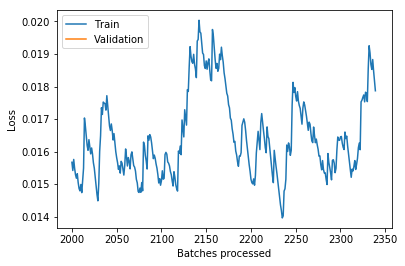

In [65]:
learn.recorder.plot_losses(skip_start=2000)

## fin